##UNET 구현

아래 모델 아키텍쳐를 참고하여 Input으로 **512 * 512 크기의 1차원 이미지가 전달**
되었을 때를 가정하여 Unet을 구현해주세요

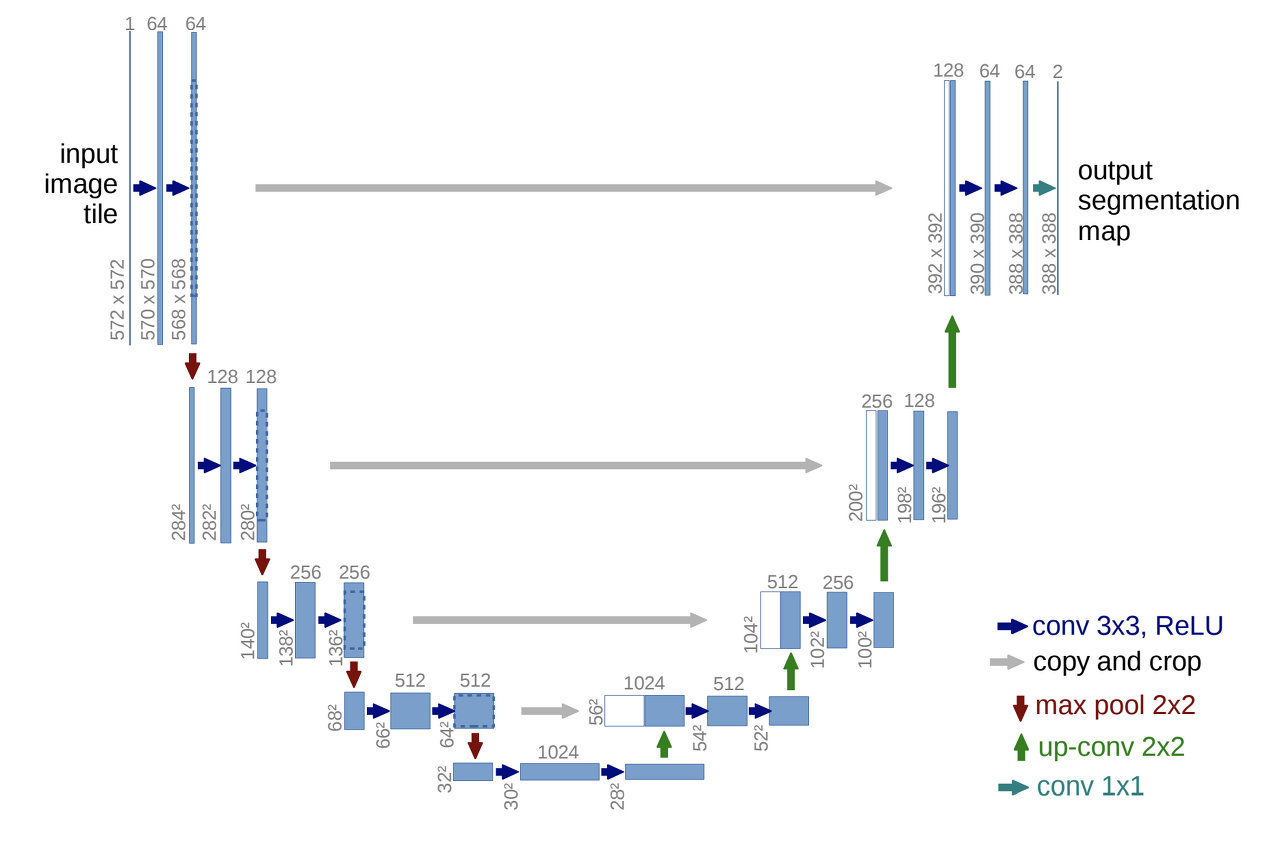

1. `Encoder 부분` : 입력 이미지의 특징을 포착하기 위해 채널의 수는 증가하고, 차원은 축소된다.

3x3 Convolution, Batch Normalization, ReLU 활성화 함수를 순차적으로 거친다. 2개의 conv block을 통해 나오는 출력 결과는 2가지로 사용된다. 첫 번째는 인코더의 다음 레이어의 입력으로 넣기 위해 max pooling으로 다운 샘플링한다. 두 번째는 디코더의 또 다른 입력으로 사용한다.

2. `Decoder 부분` : 인코딩 정보를 이용하여 채널의 수는 줄이고, 차원은 증가시켜 고차원의 이미지로 복원한다. 

이전 레이어의 출력을 transposed convolution layer를 통해 채널의 수는 줄이고 해상도를 높인 뒤, skip connectiond을 통해 인코딩 단계의 출력과 합친다.이후, encoder 부분에서 동일하게 사용한 conv block을 통해 채널 수를 줄인다.

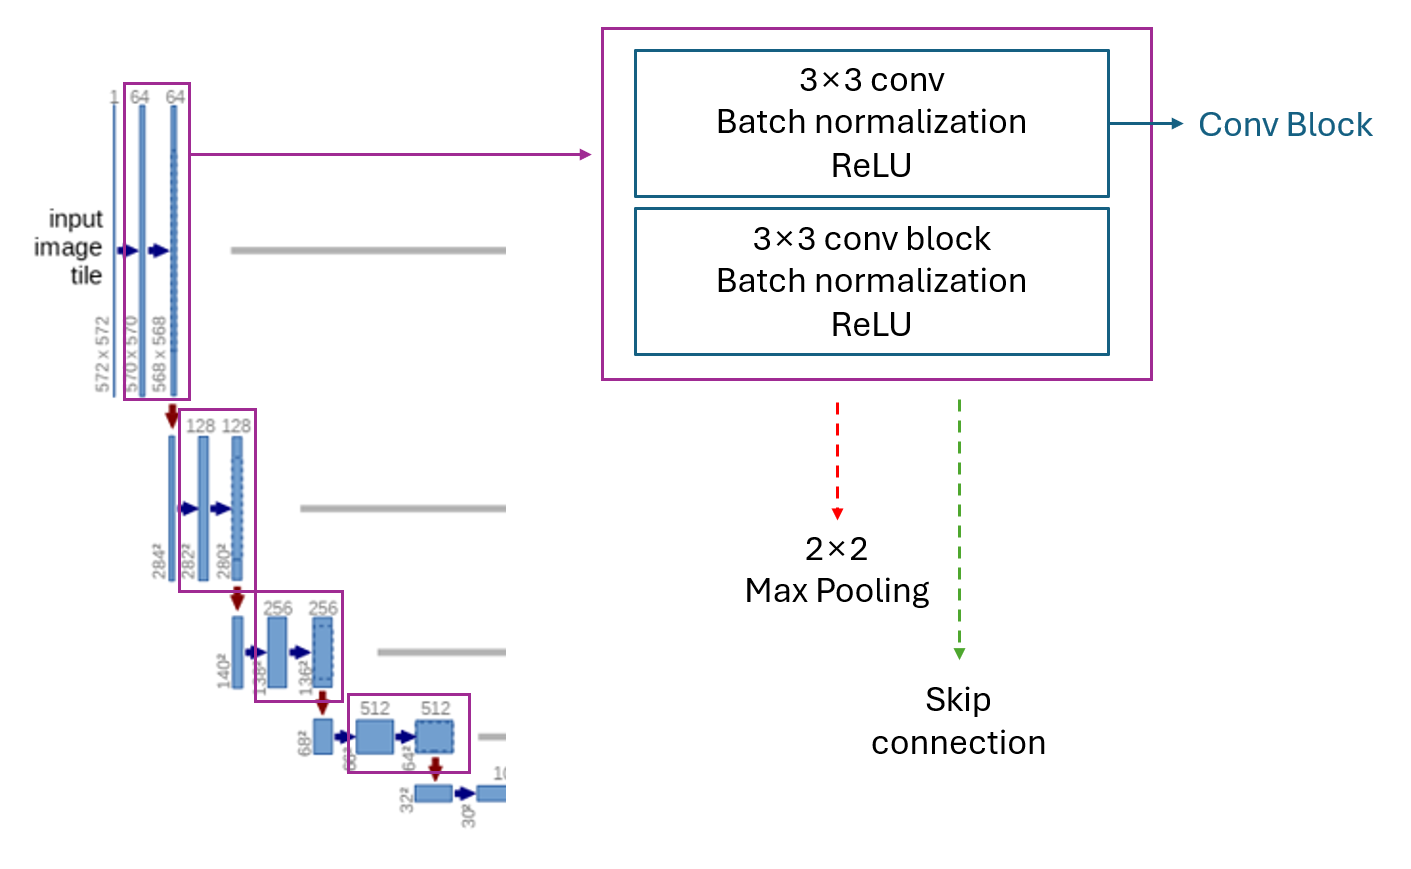

In [6]:
Image('enc.png')

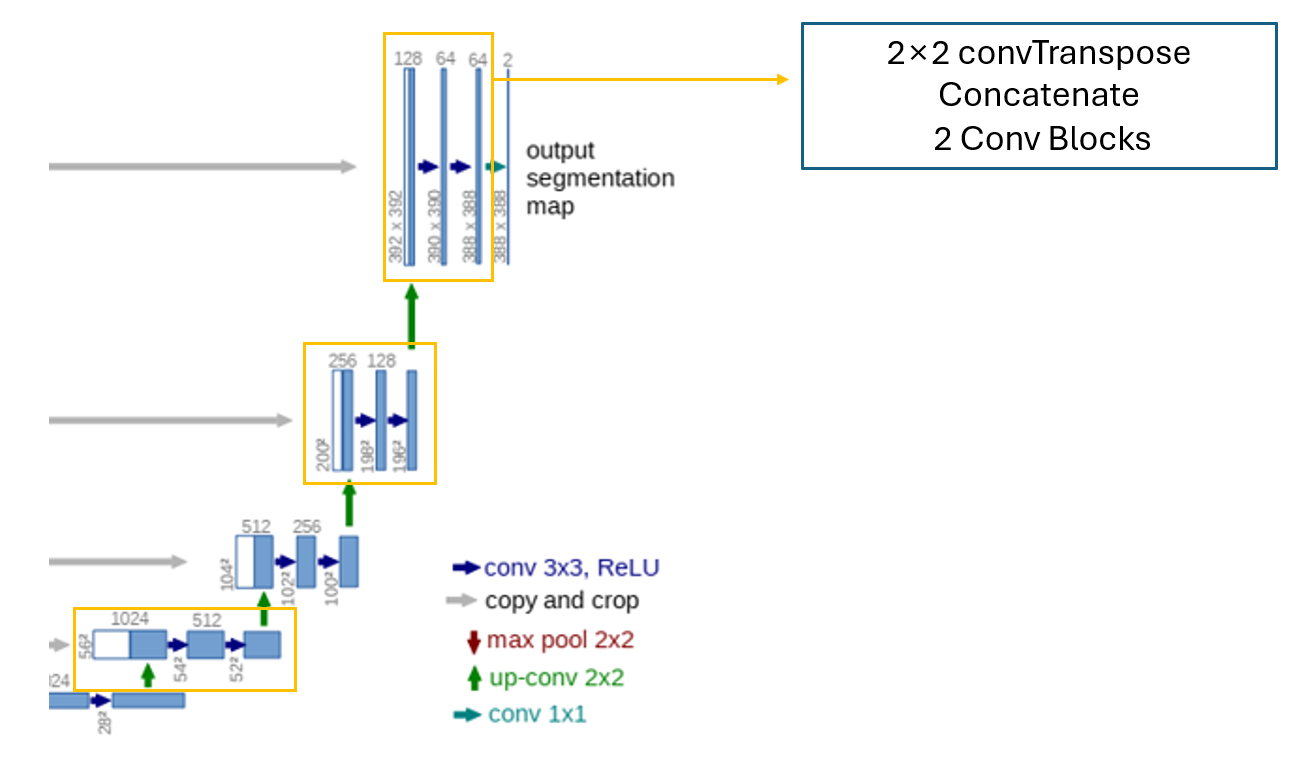

In [7]:
Image('dec.png')

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary as summary_
from IPython.display import Image

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        ############## Add Layer ##############
        # Conolution Black
        def conv_block(input_channels, output_channels, kernel_size = 3, stride = 1, padding = 'same') :
            return nn.Sequential( 
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        # Encoder
        self.enc_conv1_1 = conv_block(1,64)
        self.enc_conv1_2 = conv_block(64,64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv2_1 = conv_block(64,128)
        self.enc_conv2_2 = conv_block(128,128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv3_1 = conv_block(128,256)
        self.enc_conv3_2 = conv_block(256,256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv4_1 = conv_block(256,512)
        self.enc_conv4_2 = conv_block(512,512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv5_1 = conv_block(512,1024)
        self.enc_conv5_2 = conv_block(1024,1024)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride=2)
        self.dec_conv1_1 = conv_block(1024,512) #concatenated input data
        self.dec_conv1_2 = conv_block(512,512)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride=2)
        self.dec_conv2_1 = conv_block(512,256) 
        self.dec_conv2_2 = conv_block(256,256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride=2)
        self.dec_conv3_1 = conv_block(256,128) 
        self.dec_conv3_2 = conv_block(128,128)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride=2)
        self.dec_conv4_1 = conv_block(128,64) 
        self.dec_conv4_2 = conv_block(64,64)
        
        self.fc = nn.Conv2d(64, 1, kernel_size=1, stride=1)


    def forward(self, x):
        ############## Add Layer ##############
        e1 = self.enc_conv1_1(x)
        e1 = self.enc_conv1_2(e1)
        pool1 = self.pool1(e1)
        
        e2 = self.enc_conv2_1(pool1)
        e2 = self.enc_conv2_2(e2)
        pool2 = self.pool2(e2)
        
        e3 = self.enc_conv3_1(pool2)
        e3 = self.enc_conv3_2(e3)
        pool3 = self.pool3(e3)
        
        e4 = self.enc_conv4_1(pool3)
        e4 = self.enc_conv4_2(e4)
        pool4 = self.pool4(e4)
        
        e5 = self.enc_conv5_1(pool4)
        e5 = self.enc_conv5_2(e5)
        
        # Decoder
        d1 = self.upconv1(e5)
        d1 = torch.cat([e4, d1],dim=1)
        d1 = self.dec_conv1_1(d1)
        d1 = self.dec_conv1_2(d1)
        
        d2 = self.upconv2(d1)
        d2 = torch.cat([e3, d2],dim=1)
        d2 = self.dec_conv2_1(d2)
        d2 = self.dec_conv2_2(d2)
        
        d3 = self.upconv3(d2)
        d3 = torch.cat([e2, d3],dim=1)
        d3 = self.dec_conv3_1(d3)
        d3 = self.dec_conv3_2(d3)
        
        d4 = self.upconv4(d3)
        d4 = torch.cat([e1, d4],dim=1)
        d4 = self.dec_conv4_1(d4)
        d4 = self.dec_conv4_2(d4)
        
        out = self.fc(d4)
        
        return out


In [16]:
# model summary

model = UNet()
summary_(model, (1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]          73,856
       BatchNorm2d-9        [-1, 128, 256, 256]             256
             ReLU-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]         147,584
      BatchNorm2d-12        [-1, 128, 256, 256]             256
             ReLU-13        [-1, 128, 256, 256]               0
        MaxPool2d-14        [-1, 128, 1

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [3]:
# model summary

model = UNet()
summary_(model, (1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]          73,856
       BatchNorm2d-9        [-1, 128, 256, 256]             256
             ReLU-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]         147,584
      BatchNorm2d-12        [-1, 128, 256, 256]             256
             ReLU-13        [-1, 128, 256, 256]               0
        MaxPool2d-14        [-1, 128, 1

Skip connection이 무엇이며 어떤 효과가 있는 지 설명해주세요.


답변 : 

  NN을 학습할 때 층이 깊어질수록, 파라미터 수가 기하급수적으로 증가하면서 Vanishing gradient 문제가 발생할 수 있다. 이를 해결하기 위한 방안으로 Skip connection이 있다. Skip Connection은 이전 레이어의 저차원 정보를 넘겨주어 고차원 정보와 함께 학습할 수 있도록 한다. 이를 통해 학습 시 더 빠르게 수렴할 수 있다.
  
  
  U-net의 경우, long skip connection 구조로 인코딩 단계의 각 레이어에서 얻은 특징을 디코딩 단계의 각 레이어에 합치는(concatenate) 방법을 사용한다. long skip connection은 downsampling 동안 손실되는 spatial 정보를 회복하기 위해 contracting path (encoding) 에서 expanding path(decoding)로 features를 skip하기 위해 사용된다.따라서, 디코더는 인코더로부터 직접 전달된 고차원 정보를 사용하여 보다 선명하고 정확한 이미지를 복원할 수 있다.
 